# Image deconvolution using Maximum Entropy Methods

This is a brief introduction and example on how to use Maximum Entropy Methods (MEM) to deconvolve blurred images.
MEM was developed in the 1980's and often applied to reconstruct astronomical images from patchy radio data. An excellent review on the subject can be found <a href="https://ui.adsabs.harvard.edu/abs/1986ARA%26A..24..127N">here</a>. The authors focus largely on interferometric data in the Fourier domain. For simplicity, we will look at an example in the spatial domain.


Often in astronomy we have observations of an object (such as a cloud or a galaxy) which have been degraded by the Point-Spread Function (PSF) and detector noise of an instrument. In many cases, the form of the PSF and noise is well-known, hinting at the possibility that this information could be used to "reverse-engineer" the blurred image into the original object. Unfortunately, this isn't quite possible.

Let us consider a simple $\chi^2$ analysis to fit a model $\mathbf{x}$ to some observation (image) $\mathbf{y}$ with noise covariance $\mathbf{R}$ via a linear map $\mathbf{A}$ representing the PSF. Here,

\begin{equation}
\chi^2(\mathbf{x})=(\mathbf{A}\mathbf{x}-\mathbf{y})^{\mathrm{T}}\,\mathbf{R}^{-1}(\mathbf{A}\mathbf{x}-\mathbf{y})\,.
\end{equation}

On the surface, it appears like the most-likely $\mathbf{x}$ can be found by minimizing the above equation, i.e. solving

\begin{equation}
\nabla\chi^2(\mathbf{x})=2\,\mathbf{A}^\mathrm{T}\mathbf{R}^{-1}(\mathbf{A}\mathbf{x}-\mathbf{y})=0\,.
\end{equation}

However in nearly all cases, the resultant set of simultaneous equations are ill-posed and can have an infinite number of solutions. Thankfully, MEM can be used to select the solution which contains the least prior information, i.e. the maximum entropy.

The information entropy of $\mathbf{x}$ is given by

\begin{align}
S(\mathbf{x})=&-\sum\limits_i f_i\,\ln(f_i)\,;\\
f_i=&\frac{x_i}{\sum\limits_j x_j}\,.
\end{align}

This behaves similar to thermodynamic entropy; a thermalised system with all values of $x_i$ equal to each other (a blank field) will have maximum entropy. Conversely, a system with one finite $x_i$ and the rest zero (e.g. a point source) will have minimum entropy. This can be used to define a Bayesian prior which maximises the entropy of $\mathbf{x}$, therefore minimising the the amount of <i>a priori</i> information. Here,

\begin{align}
\ln P(\mathbf{x}|\mathbf{y})=&\ln P(\mathbf{x})+\ln P(\mathbf{y}|\mathbf{x})+\mathrm{Constant}\,;\\
=&\alpha S(\mathbf{x})-\frac{\chi^2(\mathbf{x})}{2}\,,
\end{align}

where we can ignore the constant term. The hyperparameter $\alpha$ is a normalisation constant, similar to the Boltzmann constant, the value of which we'll discuss later. A full Bayesian analysis is computationally challenging, given the high dimensionality of $\mathbf{x}$. However, we can estimate the most likely $\mathbf{x}$ using standard variational techniques.

# Worked example

Let's have a look at an illustrative example which is simple enough to be solved in a few minutes with scipy. In reality these techniques would be applied to much larger sets of data using a more scalable set of tools. Here we will set the number of model pixels to the same number as the image. In general, this does not need to be true. Indeed, the model and image can have different dimensions entirely. For example, the <a href="https://arxiv.org/abs/1509.08699">PPMAP</a> algorithm generates a position-position-temperature model from position-position-wavelength data.

## Observational data

First, we'll import an image $\mathbf{z}$ which we'll use as the underlying "truth" of the observational data.

In [1]:
import pickle
import numpy as np
from matplotlib import pyplot as plt
"""
jar=open("image.pickle","rb")
image=pickle.load(jar)
jar.close()

"""

image=plt.imread("lenna.tif")
#image=plt.imread("will.jpg").sum(axis=-1)

# pack the image into a vector called z
n_xpix=image.shape[0]
n_ypix=image.shape[1]
z=image.flatten()

# plot the image
def plot_vec(v,title=""):
    
    fig,ax=plt.subplots(1,1,figsize=(12,6))
    im=ax.imshow(v.reshape((n_xpix,n_ypix)),vmin=0.)
    cbar=fig.colorbar(im,ax=ax)
    ax.set_title(title)
    fig.tight_layout()

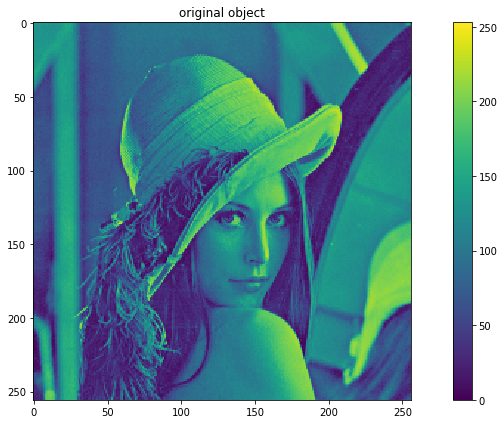

In [2]:
plot_vec(z,"original object")

Next, we convolve $\mathbf{z}$ to $\mathbf{y}$. The PSF and noise can take pretty much any form, but here we use two simple prescriptions. We use a 2D Gaussian PSF with width $h$,

\begin{equation}
    w(r)=\frac{1}{2\pi h^2}\exp\left(-\frac{r}{2h^2}\right)\,,
\end{equation}

and noise,

\begin{equation}
    \sigma_{y_i}^2=(f_1\bar{y})^2+\left(f_2\sqrt{\frac{y_i}{\bar{y}}}\right)^2\,.
\end{equation}

Roughly speaking, $f_1$ defines the background noise as a fraction of the average intensity, and $f_2$ defines the local noise as a fraction of the square root of the intensity. To reiterate, the PSF and noise can take any form, but they need to be well defined/estimated in order to proceed with the analysis.

In [3]:
from scipy.sparse import dok_matrix
from scipy.sparse import csr_matrix
from scipy.sparse import diags

# set width of PSF as a multiple of pixel width
h=3.
r_pix=1./np.sqrt(n_xpix*n_ypix)
h_abs=h*r_pix

# compact support radius in units of h
h_cs=3

# set noise level to a multiple of mean image intensity
# noise**2 = (noise_bg*y.mean())**2
#           +(noise_sn*sqrt(y/y.mean()))**2
f1=0.01
f2=0.01

# set positions for each pixel
rx,ry=np.meshgrid(np.linspace(0.,1.,n_xpix),np.linspace(0.,1.,n_ypix),indexing="ij")
rx=rx.flatten()
ry=ry.flatten()


# define a Gaussian PSF
def PSF(r2,h2,dA):
    
    # r2: distance squared
    # h2: width squared
    # dA: pixel area
    
    # 2d gaussian
    w=np.where((r2/h2)<=h_cs**2,np.exp(-r2/(2*h2))/(2.*np.pi*h2),0.)*dA
    
    return w

# perform some broadcasting Kung Fu to get indices of A
jr=np.ceil(h*h_cs).astype(np.int)
jx,jy=np.meshgrid(np.arange(-jr,jr+1),np.arange(-jr,jr+1),indexing="ij")
jx=jx.flatten()
jy=jy.flatten()

i=np.arange(z.size)
y_off=np.mod(i,n_ypix)
x_off=((i-y_off)//n_ypix)
jy=jy[np.newaxis,:]+y_off[:,np.newaxis]
jx=jx[np.newaxis,:]+x_off[:,np.newaxis]

j=(jx*n_ypix+jy).flatten()
i=(np.arange(z.size)[:,np.newaxis]+np.zeros((2*jr+1)**2,np.int)[np.newaxis,:]).flatten()

ij=np.stack((i,j),-1)
ij=ij[np.logical_and(ij[:,1]>=0,ij[:,1]<z.size)]

# calculate distances
r2=(rx[ij[:,0]]-rx[ij[:,1]])**2+(ry[ij[:,0]]-ry[ij[:,1]])**2

# set matrix
data=PSF(r2,h_abs**2,r_pix**2)

A=csr_matrix((data,ij.T),shape=(z.size,z.size))

# apply PSF to z
y=(A*csr_matrix(z).T).toarray().flatten()

# add noise to y
noise=np.sqrt((f1*y.mean())**2+(f2*np.sqrt(y/y.mean()))**2)

y=np.random.normal(y,noise)

# pack noise values into diagonal array R^-1
R_inv=diags(1./noise**2,0)

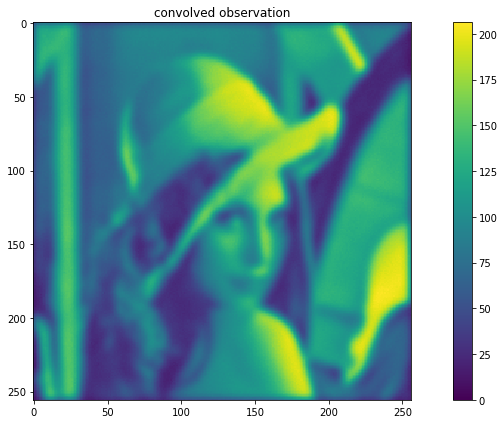

In [4]:
plot_vec(y,"convolved observation")

As you can see, we've generated a blurred, noisy image $\mathbf{y}$ from our imported image $\mathbf{z}$, via the linear map $\mathbf{A}$. We will use this same linear map in our analysis. We've also assumed that the noise values are uncorrelated, therefore $\mathbf{R}^{-1}$ is diagonal matrix with $R^{-1}_{ii}=1/\sigma_{y_i}^2$. A point to note is that $\mathbf{A}$ and $\mathbf{R}^{-1}$ are stored as sparse matrices, meaning that computational costs and storage requirements are fairly low.

## Loss-function minimisation

In order to find $\mathbf{x}$, we have to simultaneously solve two problems: i) minimise the loss function,

\begin{equation}
J(\mathbf{x})=-\alpha S(\mathbf{x})+\frac{\chi^2(\mathbf{x})}{2}\,,
\end{equation}

and ii) find a value for $\alpha$ such that $\chi^2\sim N\pm\sqrt{N}$ when $\nabla J(\mathbf{x})=0$, where$ N$ is size of the observation vector $\mathbf{y}$.

This can be achieved by arbitrarily selecting two values of $\alpha$ and performing iterations of the <a href="https://en.wikipedia.org/wiki/Secant_method">secant method</a> to solve $\chi^2-N=0$ to a tolerance of $\pm\sqrt{N}$. During each iteration, we use the <a href="https://en.wikipedia.org/wiki/Conjugate_gradient_method">conjugate gradient method</a> to solve $\nabla J(\mathbf{x})=0\,$.

Thankfully, scipy already has implementations of these methods. In order to maximise the efficiency of the algorithm, need to be able to calculate (but not necessarily store) the first and second partial derivatives of $J(\mathbf{x})$:

\begin{align}
    \nabla J(\mathbf{x})&=-\alpha\nabla S(\mathbf{x})+\mathbf{A}^\mathrm{T}\mathbf{R}^{-1}(\mathbf{A}\mathbf{x}-\mathbf{y})\,;\\
    \mathbf{H}J(\mathbf{x})&=-\alpha\,\mathbf{H}S(\mathbf{x})+\mathbf{A}^\mathrm{T}\mathbf{R}^{-1}\mathbf{A}\,.
\end{align}

Thankfully, we don't have to compute the entire Hessian! We only have to provide a function which supplies $\mathbf{H}J(\mathbf{x})\,\mathbf{p}$, the product of the Hessian and an arbitrary vector $\mathbf{p}$. The entropy gradient $\nabla S(\mathbf{x})$ and Hessian matrix $\mathbf{H}S(\mathbf{x})$ have pretty ugly analytical forms which we'll list and the end of this notebook.

In [5]:
# define a very small number
tiny=np.finfo(1.).eps

# precompute some matrices
ATR_inv=A.T*R_inv
y=csr_matrix(y).T


# define new log x function
# doesn't blow up if x is slightly negative!
def ln(x):
    
    #return np.log(x)
    return np.log(np.where(x>0.,x,tiny))


# loss function
def J(x,alpha):
    
    sum_x=x.sum()
    f=x/sum_x
    S=-(f*ln(f)).sum()
    
    x_mat=csr_matrix(x).T
    Ax_y=A*x_mat-y
    chi2=(Ax_y.T*R_inv*Ax_y).toarray()[0,0]
    
    result=-alpha*S+0.5*chi2
    
    return result

# grad loss function
def grad_J(x,alpha):
    
    sum_x=x.sum()
    f=x/sum_x
    log_f=ln(f)
    grad_S=(((x*log_f).sum()-x*log_f)-(sum_x-x)*log_f)/sum_x**2
    
    x_mat=csr_matrix(x).T
    Ax_y=A*x_mat-y
    grad_chi2=(ATR_inv*Ax_y).toarray().flatten()
    
    result=-alpha*grad_S+grad_chi2
    
    return result

# Hessian of loss function times vector
def hessp_J(x,p,alpha):
    
    sum_x=x.sum()
    f=x/sum_x
    log_f=ln(f)
    x_log_f=x*log_f
    sum_x_log_f=(x*log_f).sum()
    # set diagonal component
    diag=p*(sum_x**2-sum_x*x-x**2
            +2*x*(sum_x_log_f-x_log_f)
            -2*(sum_x-x)*x_log_f)/(-x*sum_x**3)
    # set off-diagonal component
    # independent part
    off_diag=p.sum()*(sum_x-2*sum_x_log_f)
    # set column-dependent part
    temp_term=(sum_x-2*x)*log_f+2*x_log_f
    off_diag+=(p*(temp_term)).sum()
    # set row-dependent part
    off_diag+=p.sum()*temp_term
    # remove erroneous diagonal part
    off_diag-=p*(sum_x-2*sum_x_log_f
                 +2*(temp_term))
    # normalize
    off_diag/=sum_x**3
    hessp_S=diag+off_diag
    
    
    Ap=A*csr_matrix(p).T
    hessp_chi2=(ATR_inv*Ap).toarray().flatten()
    
    result=-alpha*hessp_S+hessp_chi2
    
    return result

In [ ]:
from scipy.optimize import minimize
from scipy.optimize import newton
import time

# initialise model vector
x=np.full(y.size,1.)

# initialse alpha
# start with a high value and relax it to optimum
log_alpha_0=np.log(x.size)+6.
log_alpha_1=log_alpha_0-1.
alpha_tol=np.log(1.+1./np.sqrt(x.size))


# set iteration count
i=0

# define secant iteration
def secant_it(log_alpha):
    
    global x
    global i
    
    i+=1
    alpha=np.exp(log_alpha)
    print("iteration:",i)
    print("alpha:",alpha)
    
    # perform conjugate gradient minimisation
    start_time=time.time()
    res=minimize(J,x,args=alpha,method="trust-ncg",jac=grad_J,hessp=hessp_J)
    
    # next iteration will be faster if we use this result as initial state
    x=res.x
    
    # get reduced chi2
    x_mat=csr_matrix(x).T
    Ax_y=A*x_mat-y
    chi2=(Ax_y.T*R_inv*Ax_y).toarray()[0,0]
    log_red_chi2=np.log(chi2)-np.log(x.size)
    print("reduced chi^2:",np.exp(log_red_chi2))
    print("time taken (s):",time.time()-start_time)
    print()
    plot_vec(x,"iteration "+str(i))
    
    return log_red_chi2

# perform secant iterations
print("solving for x")
root=newton(secant_it,log_alpha_0,x1=log_alpha_1,tol=alpha_tol)

solving for x
iteration: 1
alpha: 26439109.410339925
reduced chi^2: 9.436321374798663
time taken (s): 58.91168427467346

iteration: 2
alpha: 9726404.794946473
reduced chi^2: 2.6855455954193674
time taken (s): 37.51147937774658

iteration: 3
alpha: 4431506.5311176805
reduced chi^2: 1.4491273311091424
time taken (s): 45.4918475151062

iteration: 4
alpha: 3111492.417049961
reduced chi^2: 1.2357833744348377
time taken (s): 52.127875089645386

iteration: 5
alpha: 1944491.5227503264
reduced chi^2: 1.0843087722987699
time taken (s): 50.80658483505249

iteration: 6
alpha: 1453543.7214705835
reduced chi^2: 1.031706233687954
time taken (s): 64.27505278587341

iteration: 7
alpha: 1210884.1336099498
reduced chi^2: 1.0081831509945227
time taken (s): 52.08823084831238

iteration: 8
alpha: 1135200.1067938139


In [ ]:
plot_vec(z,"original object")

In [ ]:
plot_vec(y.toarray(),"observation")

In [ ]:
plot_vec(x,"MEM solution")

Essentially, the $\mathbf{x}$ is the model solution with the maximum possible entropy, given the constraint $\chi^2\sim N\pm\sqrt{N}$. Hopefully you can see that $\mathbf{x}$ has roughly double resolution of $\mathbf{y}$ although some of the high frequency noise has been translated to lower frequencies.

## Uncertainties

Finally, as scientists, these analyses aren't much use to us without uncertainty maps. Thankfully we've nearly calculated them already. The covariance matrix of $\mathbf{x}$ is related to the loss function:

\begin{equation}
    \Sigma(\mathbf{x})=2[\mathbf{H}J(\mathbf{x})]^{-1}\,.
\end{equation}

While the full Hessian and its inverse are prohibitively expensive to calculate, we only need the diagonal elements to estimate the variances for each value of $\mathbf{x}$.

In [ ]:
# get diagonal elements of loss function Hessian

def hess_diag_J(x,alpha):
    
    # S Hessian
    sum_x=x.sum()
    f=x/sum_x
    log_f=ln(f)
    x_log_f=x*log_f
    sum_x_log_f=(x*log_f).sum()
    hess_diag_S=(sum_x**2-sum_x*x-x**2
            +2*x*(sum_x_log_f-x_log_f)
            -2*(sum_x-x)*x_log_f)/(-x*sum_x**3)
    
    # chi2 Hessian
    hess_diag_chi2=np.array((ATR_inv.multiply(A)).sum(axis=0)).flatten()
    
    result=-alpha*hess_diag_S+hess_diag_chi2
    
    return result

# calculate stdv for x
alpha=np.exp(root)
sigma_x=np.sqrt(2./hess_diag_J(x,alpha))

In [ ]:
plot_vec(sigma_x,"noise map")

In [ ]:
plot_vec(x/sigma_x,"signal to noise")

It's worth noting that the signal to noise is probably a little lower than what you're comfortable with. This is because the pixel values of $\mathbf{x}$ are locally anti-correlated thanks to the PSF. They can effectively "jiggle about" within the PSF, so long as their combined value adds up to that of $\mathbf{y}$. Whether you're happy with this, or want to reduce the noise by sub-sampling the image is up to you.

## Entropy first and second partial derivatives

Thanks to a bit of mucking around on <a href="https://www.wolframalpha.com/">Wolfram</a>, we find that the elements of the entropy gradient $\nabla S(\mathbf{x})$ vector are given by

\begin{align}
    \frac{\partial S}{\partial x_i}=&\frac{F-x_i\ln(f_i) - \left(X - x_i \right)\ln(f_i)}{X^2}\,;\\
    f_i=&\frac{x_i}{X}\,;\\
    X=&\sum\limits_j x_j\,;\\
    F=&\sum\limits_j x_j\ln(f_j)\,.
\end{align}

Members of the entropy Hessian $\mathbf{H}S(\mathbf{x})$ matrix are given by

\begin{align}
    \frac{\partial^2 S}{\partial x_i^2}=&\frac{X^2-x_i^2-x_iX +2x_i(F-x_i\ln(f_i))-2x_i(X-x_i)\ln(f_i)}{x_iX^3}\,;\\
    \frac{\partial^2 S}{\partial x_i \partial x_{j\neq i}}=&\frac{X+(X-2x_i)\ln(f_i)-2(F-x_i\ln(f_i)-x_j\ln(f_j))+(X-2x_j)\ln(f_j)}{X^3}\,.
\end{align}

Note: these are correct to the best of my knowledge, but I have been wrong before! Let me know if you find any errors!
